# OpenABM-Covid19 - Example Self-Isolation After Testing

This examples demonstrates the importance of quick testing if self-isolation only occurs following a positive test.

First we set the baseline parameters: change the population to 50k (`n_total=50000`); turn off self-quarantining on symptoms (`quarantine_length_self=0`); set the length and daily drop-out rate of quarantining following a positive test (`quarantine_length_positive=14` and `quarantine_dropout_positive=0.02`); and set the test sensitivity to 90% (`test_sensitivity=0.9`). At the start of the simulation there is no self-isolation and we run the simulation for 15 days.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from COVID19.model import Model as abm

params = {
    "n_total" : 50000 , 
    "quarantine_length_self" : 0,
    "quarantine_length_positive" : 14,
    "quarantine_dropout_positive" : 0.02,
    "test_sensitivity" : 0.9 }
model = abm( params = params)
for t in range(15):
    model.one_time_step()

After 15 days we turn on interventions for those with symptoms. Setting `self_quarantine_fraction=0.8` means that 80% of the those with symptoms enter the intervention cascade (by default this would mean self-isolation, but setting `quarantine_length_self=0` means there is no initial self-isolation). A test is ordered (`test_on_symptoms=1`) immediately (`test_order_wait=0`) and a result comes back after 24hrs (`test_result_wait=1`) . If the result is positive then the individual and their household quarantines and the simulation is run for 25 days.

In [2]:
model.update_running_params("self_quarantine_fraction", 0.8 )
model.update_running_params("quarantine_household_on_positive", 1)
model.update_running_params("test_on_symptoms", 1)
model.update_running_params( "test_order_wait", 0 )
model.update_running_params( "test_result_wait", 1 )
for t in range(25):
    model.one_time_step()

timeseries = model.results 

We now re-run the simulation but with slower testing, including a 1 day wait for the test to be done and a 3 day wait for the test result.

In [3]:
del( model );
model = abm( params = params)
for t in range(15):
    model.one_time_step()

model.update_running_params("self_quarantine_fraction", 0.8 )
model.update_running_params("test_on_symptoms", 1)
model.update_running_params( "test_order_wait", 1 )
model.update_running_params( "test_result_wait", 3 )
model.update_running_params("quarantine_household_on_positive", 1)
for t in range(25):
    model.one_time_step()

Plot the number of daily new infections over the course of the simulation and compare between quick and slow testing.

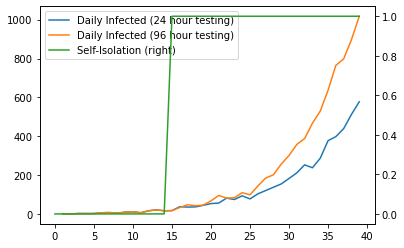

In [4]:
timeseries2 = model.results 
timeseries["daily_infected"] = timeseries["total_infected"].diff(1)
timeseries2["daily_infected_slow"] = timeseries2["total_infected"].diff(1)
df = pd.merge( timeseries, timeseries2, on = "time")
df["self_isolate"] = timeseries.apply(lambda X: 1 if ( X.time >15) & ( X.time <= 40 ) else 0, axis=1)

plt.figure()
df.daily_infected.plot( x = "time", legend = True, label = "Daily Infected (24 hour testing)" )
df.daily_infected_slow.plot( x = "time", legend = True, label = "Daily Infected (96 hour testing)" )
df.self_isolate.plot( x = "time", legend = "True", secondary_y = True, label = "Self-Isolation" )